# COMP90051 Project 2

In [102]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [103]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [104]:
class MABBase(MAB):
    """
    MAB Base Class for multi-armed bandits (MAB) classes that implements the needed functionalities. It
    inherits and implements the methods of MAB Abstract class (Use of Inheritance)
    """
    
    def __init__(self, narms, ndims=0, Q0=0):
        
        if narms < 1:
            raise ValueError("Number of arms should not be less than 1")
        self._narms = narms
        self._ndims = ndims
        
        # Initialise qvalues, rewards and counts for each arms in MAB
        self._qvalues = np.full(narms, Q0)
        self._playcounts = np.zeros(narms, dtype=int)
        self._totalrewards = np.zeros(narms, dtype=float)
        
        # Initialise and map arm indices to arm numbers and arm names
        self._arm_indices = {i + 1: i for i in np.arange(0, narms)}
        self._arm_names = [i + 1 for i in np.arange(0, narms)]
        
        # reward history for arms
        self._rewardshistory = []
        
        
    def _get_arm_index(self, arm):
        """
        Method that validates arm and returns its index
        
        """
        if arm in self._arm_indices.keys():
            arm_idx = self._arm_indices[arm]
        else:
            raise ValueError('Invalid arm number {}.'.format(arm))
        return arm_idx
    
    
    def play(self, tround, context=None):
        '''
        Checks for input parameters
        '''
        if not isinstance(tround, int):
            raise ValueError('tround is expected to be integer')
        played = len(self._rewardshistory)
        if tround - played != 1:
            raise ValueError("Invalid round number {}.  {} rounds have been played".format(tround, played))
                             
                             
    def update(self, arm, reward, context):
       
        '''
        Checks for input parameters and updates reward history
        '''      
        if not isinstance(reward, float):
            raise ValueError("reward is expected to be float")
        self._rewardshistory.append(reward)
        
        

        

In [105]:
class EpsGreedy(MABBase):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    #EpsGreedy inherits the MAB Base class 
    def __init__(self, narms, epsilon, Q0=np.inf):
        
        #validation for epsilon value
        if epsilon < 0:
            raise ValueError("Epsilon could not be negative")
        self._epsilon = epsilon
        #inherit narms and Q0 from MAB Base class
        super().__init__(narms, Q0=Q0)
        
        
    def play(self, tround, context=None):
        
        #inherit tround and context from MAB Base class
        super().play(tround, context)
        
        # Sample random variable 
        x = np.random.uniform()
        
        # Choose explore or exploit based on x sample value
        if x < self._epsilon:
            # Explore
            arm_idx = np.random.randint(0, self._narms)
        else:
            # Exploit
            indices = np.argwhere(self._qvalues == self._qvalues.max()).flatten()
            #random choice for tie breaking between indices
            arm_idx = np.random.choice(indices)
            
        return self._arm_names[arm_idx]
        

        
    def update(self, arm, reward, context=None):
        
        #inherit tround and context from MAB Base class
        super().update(arm, reward, context)
        arm_idx = self._get_arm_index(arm)
        
        # Save arm and reward
        self._playcounts[arm_idx] += 1
        self._totalrewards[arm_idx] += reward
      
        
        # Update qvalue
        qvalue = self._totalrewards[arm_idx] / self._playcounts[arm_idx]
        self._qvalues[arm_idx] = qvalue
       
        
    

In [106]:
class UCB(MABBase):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        
        self._rho = rho
        #inherit narms , Q0 from MAB Base class
        super().__init__(narms, Q0=Q0)
        
    
    def play(self, tround, context=None):
        
        #inherit tround , context from MAB Base class
        super().play(tround, context)
        values = np.argwhere(self._qvalues == self._qvalues.max())
        indices = values.flatten()
        #randomly choosing for tie breaking
        arm_idx = indices[np.random.randint(0, indices.shape[0])]
        return self._arm_names[arm_idx]
         
 
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        arm_idx = self._get_arm_index(arm)
        
        # update play counts and total reward
        self._playcounts[arm_idx] += 1
        self._totalrewards[arm_idx] += reward
        
        # Update qvalues
        num = self._rho * np.log(self._playcounts.sum() + 1)
        indices = self._playcounts > 0
        self._qvalues[indices] = self._totalrewards[indices] / self._playcounts[indices] +\
                                    np.sqrt(num / self._playcounts[indices])

## 2. The Basic Thompson Bandit

In [107]:
class BetaThompson(MABBase):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        
        super().__init__(narms)
        #initialise alpha and beta
        self._arms_alpha_beta = [[alpha0, beta0]] * narms
        self._times_played = np.zeros(narms)
        self._rewards = np.zeros(narms)
       

        
    
    def play(self, tround, context=None):
        
        #sample alpha and beta values from the beta distribution of all arms
        _beta_distributions = [np.random.beta(i[0],i[1]) for i in self._arms_alpha_beta]
        
        #get maximum value from the beta distributions
        _max_value = np.argmax(_beta_distributions)
        
        # randomly breaking ties
        
        _tie = np.argwhere(_beta_distributions == np.amax(_beta_distributions))
        if len(_tie) > 1:
            arm_idx = np.random.choice([j[0] for j in _tie]) 
        else:
            arm_idx = _max_value
        
        return self._arm_names[arm_idx]
        
        
    def update(self, arm, reward, context=None):
        
        arm_idx = arm - 1
        self._times_played[arm_idx] = self._times_played[arm_idx]+ 1
        arm_count = self._times_played[arm_idx]
        arm_value = self._rewards[arm_idx]
        
        #obtain alpha and beta value separately
        _alpha_val = self._arms_alpha_beta[arm_idx][0]
        _beta_val = self._arms_alpha_beta[arm_idx][1]
        
        #alpha and beta values get updated after each play
        updated_alpha_value = _alpha_val + reward
        updated_beta_value = _beta_val + (1 - reward)
        self._arms_alpha_beta[arm_idx][0] = updated_alpha_value 
        self._arms_alpha_beta[arm_idx][1] = updated_beta_value

        _reward_value = ((arm_count-1) / float(arm_count)) * arm_value + (1 / float(arm_count)) * reward
        
        self._rewards[arm_idx] = _reward_value
        
        

## 3. Off-Policy Evaluation

In [108]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
     
    _event_rewards = []
    # length of current n events
    _nevents = arms.shape[0] 
    #current index
    i = 0 
    #current round
    tround = 1 
    
    while (tround <= nrounds):
        if i >= _nevents:
            break
        while (i < _nevents):
            current_context = contexts[i]
            current_arm = arms[i]
            current_reward = rewards[i]
            i += 1
            #play the arm using current context in tround 
            _selected = mab.play(tround, current_context)
            # update the mab and append the event rewards list
            if _selected == current_arm:
                mab.update(_selected, float(current_reward), current_context)
                _event_rewards.append(current_reward)
                break
        #increment the trounds
        tround += 1
    
    #return the float array
    return np.array(_event_rewards)
    

In [109]:
'''
Loading the dataset from the text file and store them as arms, rewards and contexts
'''
arms = []
rewards = []
contexts = []
with open("dataset.txt") as file:
    read_file = file.read()
    #appends arms
    for i in range(0,len(read_file.split('\n'))-1):
        arms.append(read_file.split('\n')[i].split(' ')[0])
    #appends rewards
    for j in range(0,len(read_file.split('\n'))-1):
        rewards.append(read_file.split('\n')[j].split(' ')[1])
    #appends contexts
    for k in range(0,len(read_file.split('\n'))-1):
        contexts.append(read_file.split('\n')[k].split(' ')[2:102])
#convert lists to arrays
arms = np.asarray(arms).astype(int)
rewards = np.asarray(rewards).astype(int)
contexts = np.asarray(contexts).astype(int)

In [110]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26375


In [111]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.14375


In [112]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.11125


## 4. Contextual Bandits - LinUCB

In [113]:
class LinUCB(MABBase):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    name = 'LinUCB'
    def __init__(self, narms, ndims, alpha):
        #inherit narms and ndims from MAB base class
        super().__init__(narms=narms, ndims=ndims)
        self._alpha = alpha
        #identity matrix with ndims dimensions
        self._A = [np.identity(ndims)] * narms
        # zero vector with ndims dimensions
        self._b = np.zeros(ndims*narms).reshape((narms, ndims, 1))
        
        
    def play(self, tround, context):
        
        #inherit tround and context from MAB base class
        super().play(tround, context)
        num = self._narms
        dim = self._ndims
        #context values
        X = context.reshape((num, dim, 1))
        p = np.zeros(num)
        
        for i in np.arange(num):
            x = X[i]
            b = self._b[i]
            #inverse of A matrix
            A_inverse = np.linalg.inv(self._A[i])
            #matrix multiplication between A inverse and b
            theta = A_inverse @ b
            #compute p values 
            p[i] = theta.T @ x + self._alpha * np.sqrt(x.T @ A_inverse @ x)
        
        values = np.argwhere(p == p.max())
        indices = values.flatten()
        #random selection to solve tie breaking
        arm_idx = indices[np.random.randint(0, indices.shape[0])]
        
        return self._arm_names[arm_idx]
    
    def update(self, arm, reward, context):
        
        super().update(arm, reward, context)
        #get the arm index
        arm_idx = self._get_arm_index(arm)
        #get context value 
        x = context.reshape((self._narms, self._ndims, 1))[arm_idx]
        #update A matrix and b vector
        self._A[arm_idx] = self._A[arm_idx] + x @ x.T
        #print(self._b[arm_idx])
        self._b[arm_idx] = self._b[arm_idx] + reward * x

In [114]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [136]:
class LinThompson(MABBase):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    name = 'LinThompson' 
    def __init__(self, narms, ndims, v):
         
        #initialise variables
        self.narms = narms
        self.v = v
        self.ndims = ndims
        self.times_played = np.zeros(narms)
        self.rewards = np.zeros(narms)
        #B is a identity matrix and f is zero vector of ndims
        self.B_iden_mat = [np.identity(ndims)] * narms
        self.f = [np.zeros((ndims,1))] * narms
        #vector for computation of values
        self.values = [np.inf] * narms
        
    def compute_mu_hat(self, arm_idx, context):
        #inverse B identity matrix
        B_iden_mat_inv = np.linalg.inv(self.B_iden_mat[arm_idx])
         #get context 
        context = np.array(context).reshape(-1,1)
        #square v
        v_sq = self.v ** 2
        #update mu_hat
        mu_hat = np.dot(B_iden_mat_inv, self.f[arm_idx])
        mu_hat = mu_hat.T[0]
        #obtain sample from gaussian or normal distribution 
        sample_mu = np.random.multivariate_normal(mu_hat, v_sq * B_iden_mat_inv)
        #dot product of transpose of context and sample mu value
        current_context = np.dot(context.T, sample_mu)
        #store values in values for the arm
        self.values[arm_idx] = current_context[0]
        
    def play(self, tround, context):
      
        for arm_idx in range(self.narms):
            #computes the values directly using compute mu_hat function
            self.compute_mu_hat(arm_idx,context[(arm_idx * self.ndims):((arm_idx + 1) * self.ndims)])

        max_val = np.argmax(self.values)
        tie = np.argwhere(self.values == np.amax(self.values)) 
        #For tie breaking
        indices = tie.flatten()
        arm_idx = indices[np.random.randint(0, indices.shape[0])]
        arm = arm_idx + 1 
        return arm 
        
    
    def update(self, arm, reward, context):
        
        arm_idx = arm - 1
        #update rounds played , count and rewards 
        self.times_played[arm_idx] = self.times_played[arm_idx] + 1
        arm_count = self.times_played[arm_idx]
        arm_reward = self.rewards[arm_idx]
        updated_value = ((arm_count-1) / float(arm_count)) * arm_reward + (1 / float(arm_count)) * reward
    
        #get context
        b_context = np.array(context[(arm_idx * self.ndims):((arm_idx + 1) * self.ndims)]).reshape(-1,1)
        #store update 
        self.rewards[arm_idx] = updated_value
        #update B matrix , f vector
        self.B_iden_mat[arm_idx] = self.B_iden_mat[arm_idx] + np.dot(b_context, np.transpose(b_context))
        self.f[arm_idx] = self.f[arm_idx] + reward * b_context
        
    

In [137]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.345


## 6. Evaluation
### 6.A.

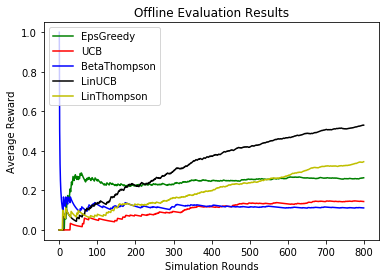

In [138]:
'''
The number of rounds is set to 800 and the average reward as total reward divided by number of counts is obtained for
each and every MAB methods
'''
#initialise number of rounds
rounds = 800
eps_greedy_rounds = np.zeros(rounds)
ucb_rounds = np.zeros(rounds)
thompson_rounds = np.zeros(rounds)
lin_ucb_rounds = np.zeros(rounds)
lin_thompson_rounds = np.zeros(rounds)
for i in range(rounds):
    eps_greedy_rounds[i]=float(np.sum(results_EpsGreedy[0:i+1]))/(i+1)
    ucb_rounds[i]=float(np.sum(results_UCB[0:i+1]))/(i+1)
    thompson_rounds[i] = float(np.sum(results_BetaThompson[0:i+1]))/(i+1)
    lin_ucb_rounds[i]=float(np.sum(results_LinUCB[0:i+1]))/(i+1)
    lin_thompson_rounds[i]=float(np.sum(results_LinThompson[0:i+1]))/(i+1)
    
# plot results
plt.plot(eps_greedy_rounds,label='EpsGreedy',color = 'g')
plt.plot(ucb_rounds,label='UCB',color = 'r')
plt.plot(thompson_rounds,label='BetaThompson',color = 'b')
plt.plot(lin_ucb_rounds,label='LinUCB',color = 'k')
plt.plot(lin_thompson_rounds, label = 'LinThompson',color = 'y')
plt.title("Offline Evaluation Results")
plt.xlabel("Simulation Rounds")
plt.ylabel("Average Reward")
plt.legend(loc = 2)
plt.show()

### 6.B.

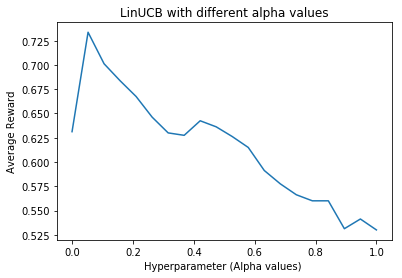

In [120]:
#Equally spaced hyperparameter alphas values between the values of 0 and 1.
hyperparameter=np.linspace(0, 1, 20)
lin_UCB_values=[]
#For each alpha values , Lin UCB is calculated and plotted.
for alpha in hyperparameter:
    mab = LinUCB(10, 10, alpha)
    lin_UCB_values.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))
plt.plot(hyperparameter,lin_UCB_values)
plt.title("LinUCB with different alpha values")
plt.xlabel("Hyperparameter (Alpha values) ")
plt.ylabel("Average Reward")
plt.show()

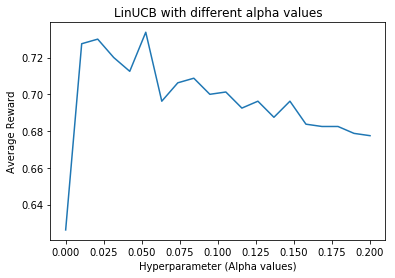

In [121]:
#Equally spaced hyperparameter alphas between the values of 0 and 0.2.
hyperparameter=np.linspace(0, 0.2, 20)
lin_UCB_values=[]
#For each alpha, calculate the linUCB result and plot it in a graph format.
for alpha in hyperparameter:
    mab = LinUCB(10, 10, alpha)
    lin_UCB_values.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))
plt.plot(hyperparameter,lin_UCB_values)
plt.title("LinUCB with different alpha values")
plt.xlabel("Hyperparameter (Alpha values)")
plt.ylabel("Average Reward")
plt.show()

It can be observed that 0.1 alpha value provides the highest average reward in the interval 0 and 1 for LinUCB.For the interval 0 and 0.2 LinUCB shows higher rewards for 0.01 and 0.05 .

In [122]:
def plot_mab(mabs, x, y, ngames):

    plt.figure(figsize=(12,6))
    for idx, mab_info in enumerate(mabs):
        mab_class, mab_params = mab_info
        params = ['{}={}'.format(key, mab_params[key]) for key in mab_params.keys()]
        label = '{} ({})'.format(mab_class.name, 
                                 ', '.join(params))
        plt.plot(x, np.mean(y[idx], axis=0), label=label)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Average reward ')
    plt.title('Average Reward by {} Instances of MAB Estimator by Round'.format(ngames))
    plt.show()

In [123]:
def evaluate_mabs(narms, mabs, arms, rewards, contexts, nrounds=800, niters=10):    
    l = nrounds
    x = np.arange(0, l)+ 1
    y = np.empty((len(mabs), niters, l))
    for niter in range(0, niters):
        
        for mab_idx, mab_info in enumerate(mabs):
            mab_class, mab_params = mab_info
            mab = mab_class(narms, **mab_params)
            y[mab_idx, niter, :] = offlineEvaluate(mab, arms, rewards, contexts, nrounds).cumsum()
            y[mab_idx, niter, :] = y[mab_idx, niter, :] / x[:]

    # ploting average rewards for each MAB
    plot_mab(mabs, x, y, niters)

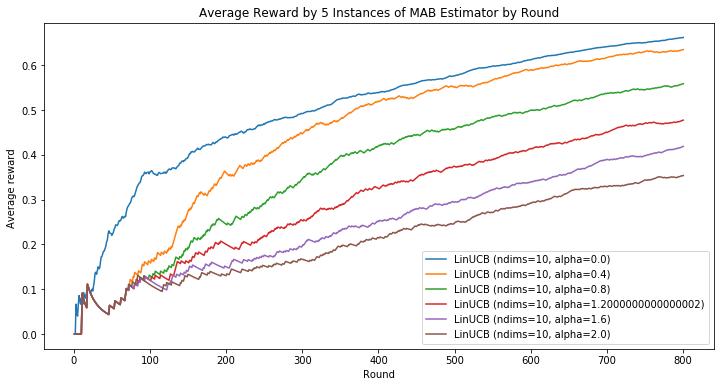

In [124]:
'''
Evaluate LinUCB for different alpha hyperparameter values for 10 arms 
'''
narms = 10
alphas = np.linspace(0, 2, 6)
mabs = np.array([(LinUCB, {'ndims': 10, 'alpha': alpha}) for alpha in alphas])
evaluate_mabs(narms, mabs, arms, rewards, contexts, niters=5)

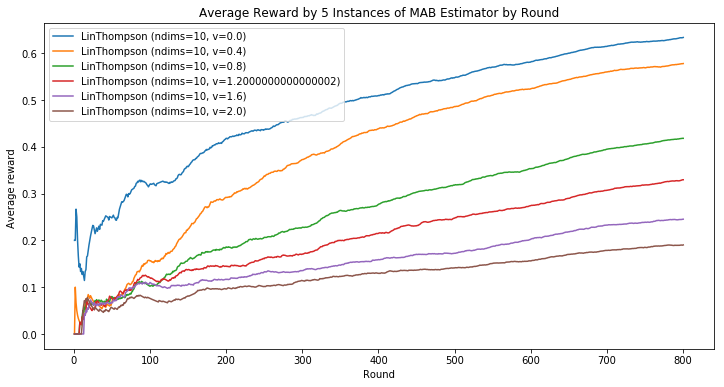

In [127]:
'''
Evaluate LinThompson for different v hyperparameter values for 10 arms 
'''
narms = 10
values = np.linspace(0, 2, 6)
mabs = np.array([(LinThompson, {'ndims': 10, 'v': v}) for v in values])
evaluate_mabs(narms, mabs, arms, rewards, contexts, niters=5)

It is observed that highest average reward is obtained when v hyperparameter is 0.

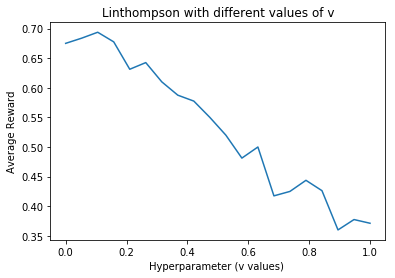

In [126]:
#Equally spaced hyperparameter v between the values of 0 and 1.
hyperparameter=np.linspace(0, 1, 20)
lin_thompson_values=[]
#For each v value is calculated and result is plotted.
for v in hyperparameter:
    mab = LinThompson(10, 10, v)
    lin_thompson_values.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))
plt.plot(hyperparameter,lin_thompson_values)
plt.title("Linthompson with different values of v")
plt.xlabel("Hyperparameter (v values) ")
plt.ylabel("Average Reward")
plt.show()